In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = '/content/drive/MyDrive/lipsync_project'
os.chdir(project_path)


Mounted at /content/drive


In [ ]:

!pip install librosa moviepy opencv-python


In [ ]:

import librosa
import numpy as np

audio_path = 'audio.wav'
y, sr = librosa.load(audio_path, sr=None)
frame_length = int(0.05 * sr)
hop_length = frame_length
energy = np.array([
    sum(abs(y[i:i+frame_length]**2))
    for i in range(0, len(y), hop_length)
])


energy = energy / np.max(energy)
print("Frames of energy:", len(energy))


Frames of energy: 639


In [ ]:

import cv2

body = cv2.imread('character_body.png', cv2.IMREAD_UNCHANGED)
mouths = {
    'V_Idle': cv2.imread('V_Idle.png', cv2.IMREAD_UNCHANGED),
    'V_A': cv2.imread('V_A.png', cv2.IMREAD_UNCHANGED),
    'V_E': cv2.imread('V_E.png', cv2.IMREAD_UNCHANGED),
    'V_O': cv2.imread('V_O.png', cv2.IMREAD_UNCHANGED),
    'V_S': cv2.imread('V_S.png', cv2.IMREAD_UNCHANGED),
}


In [ ]:
import cv2
import numpy as np

target_width = 150

for key in mouths:
    img = mouths[key]
    if img is None:
        print(f" Mouth image {key} not loaded, skipping resize.")
        continue
    h, w = img.shape[:2]
    scale = target_width / w
    new_w, new_h = int(w * scale), int(h * scale)
    mouths[key] = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

print(" All mouth images resized to ~", target_width, "px width")


def overlay_image(base, overlay, x, y):
    b = base.copy()
    h, w = overlay.shape[:2]
    H, W = b.shape[:2]


    if y + h > H: h = H - y
    if x + w > W: w = W - x

    overlay = overlay[0:h, 0:w]
    alpha = overlay[:, :, 3] / 255.0 if overlay.shape[2] == 4 else np.ones((h, w))

    for c in range(3):
        b[y:y+h, x:x+w, c] = (
            overlay[:, :, c] * alpha + b[y:y+h, x:x+w, c] * (1 - alpha)
        )
    return b


fps = len(energy) / (len(y) / sr)
frames = []

mouth_x, mouth_y = 230,140

for e in energy:
    if e < 0.2:
        mouth = 'V_Idle'
    elif e < 0.4:
        mouth = 'V_S'
    elif e < 0.6:
        mouth = 'V_E'
    elif e < 0.8:
        mouth = 'V_A'
    else:
        mouth = 'V_O'

    frame = overlay_image(body, mouths[mouth], mouth_x, mouth_y)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2RGB)
    frames.append(frame)

print("Frames generated:", len(frames))


 All mouth images resized to ~ 150 px width
Frames generated: 639


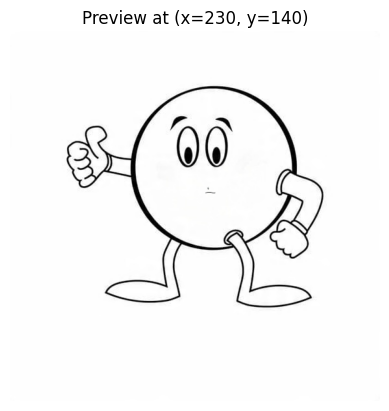

In [ ]:

import matplotlib.pyplot as plt

test_frame_idx = 10
test_energy = energy[test_frame_idx]

if test_energy < 0.2:
    mouth = 'V_Idle'
elif test_energy < 0.4:
    mouth = 'V_S'
elif test_energy < 0.6:
    mouth = 'V_E'
elif test_energy < 0.8:
    mouth = 'V_A'
else:
    mouth = 'V_O'

mouth_x, mouth_y = 230,140   # start with smaller numbers
preview = overlay_image(body, mouths[mouth], mouth_x, mouth_y)
plt.imshow(cv2.cvtColor(preview, cv2.COLOR_BGRA2RGB))
plt.axis("off")
plt.title(f"Preview at (x={mouth_x}, y={mouth_y})")
plt.show()


In [ ]:

from moviepy.editor import ImageSequenceClip, AudioFileClip

clip = ImageSequenceClip(frames, fps=fps)
audioclip = AudioFileClip('audio.wav')
final = clip.set_audio(audioclip)
final.write_videofile('lip_sync_output.mp4', codec='libx264', audio_codec='aac')


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Moviepy - Building video lip_sync_output.mp4.
MoviePy - Writing audio in lip_sync_outputTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video lip_sync_output.mp4



Moviepy - Done !
Moviepy - video ready lip_sync_output.mp4
